In [1]:
# --- Imports
import matplotlib
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
import pandas as pd
import numpy as np
from numpy import round
import scipy.stats as stats
import kan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

#### Data Preparation

In [2]:
# --- Loading Data
fp_in = pd.read_csv("../applications_datasets/fp_inp.csv")
fp_out = pd.read_csv("../applications_datasets/fp_out.csv")

X_features = ['fuel_dens','porosity','clad_thick','pellet_OD','pellet_h','gap_thick','inlet_T','enrich','rough_fuel','rough_clad','ax_pow','clad_T','pressure']
Y_features = ['fis_gas_produced','max_fuel_centerline_temp','max_fuel_surface_temp','radial_clad_dia']
X_units = fp_in.loc[0,X_features] #type:ignore
Y_units = fp_out.loc[0,Y_features] #type:ignore
X_SCALER = StandardScaler()
Y_SCALER = StandardScaler()
X = fp_in.loc[1:,X_features].astype(float).values
Y = fp_out.loc[1:,Y_features].astype(float).values



In [3]:
# --- Test Train Split
X_TRAIN, X_TESTS, Y_TRAIN, Y_TESTS = train_test_split(X, Y, test_size=0.25)
X_TRAIN_SCALED = torch.tensor(X_SCALER.fit_transform(X_TRAIN))
X_TESTS_SCALED = torch.tensor(X_SCALER.transform(X_TESTS))
Y_TRAIN_SCALED = torch.tensor(Y_SCALER.fit_transform(Y_TRAIN))
Y_TESTS_SCALED = torch.tensor(Y_SCALER.transform(Y_TESTS))
DATASET = {'train_input':X_TRAIN_SCALED, 'test_input':X_TESTS_SCALED, 'train_label':Y_TRAIN_SCALED, 'test_label':Y_TESTS_SCALED}

In [4]:
print(f"X Features Shape:\t({X.shape[0]} Samples) x ({X.shape[1]} Features)\t\tSplit Into: ({X_TRAIN.shape[0]}/{X_TESTS.shape[0]}) Train/Test Samples")
print(f"Y Features Shape:\t({Y.shape[0]} Samples) x ({Y.shape[1]} Features)\t\tSplit Into: ({Y_TRAIN.shape[0]}/{Y_TESTS.shape[0]}) Train/Test Samples")

X Features Shape:	(399 Samples) x (13 Features)		Split Into: (299/100) Train/Test Samples
Y Features Shape:	(399 Samples) x (4 Features)		Split Into: (299/100) Train/Test Samples


#### Construction and Training

In [125]:
# --- Constructing and Initial Training
model = kan.KAN(width=[X.shape[1], 14, 4, Y.shape[1]], grid=3, seed=43, device='cpu')

checkpoint directory created: ./model
saving model version 0.0


In [126]:
model(DATASET['train_input'])
#model.plot()

tensor([[ 0.0654, -0.0592,  0.1178, -0.0608],
        [ 0.0395, -0.0315,  0.0823, -0.0420],
        [-0.0050,  0.0106,  0.0216, -0.0103],
        ...,
        [ 0.1045, -0.0452,  0.0931,  0.0534],
        [ 0.0931, -0.0930,  0.0847,  0.0128],
        [ 0.0097, -0.1031,  0.0294, -0.0605]], grad_fn=<AddBackward0>)

In [127]:
model.fit(DATASET, opt='LBFGS', steps=50, lamb=0.001)
print("Complete.")

| train_loss: 4.11e-02 | test_loss: 9.35e-02 | reg: 2.14e+01 | : 100%|█| 50/50 [01:19<00:00,  1.59s/

saving model version 0.1
Complete.


In [128]:
#model.plot()

saving model version 0.2


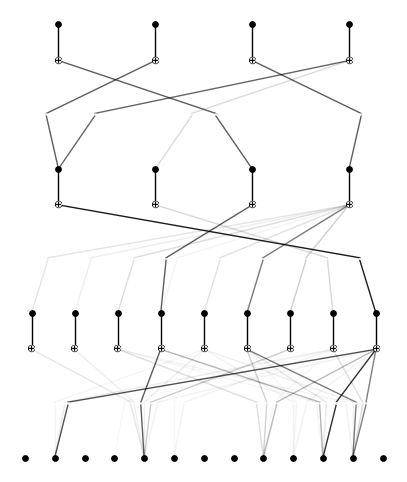

In [129]:
# --- Model Pruning and Refinement
model = model.prune(0.01, 0.01)
model.plot()

In [130]:
model = model.refine(10)

saving model version 0.3


In [131]:
model.fit(DATASET, opt='LBFGS', steps=20)
print("Complete")

| train_loss: 4.06e-02 | test_loss: 1.20e-01 | reg: 2.23e+01 | : 100%|█| 20/20 [00:30<00:00,  1.53s/

saving model version 0.4
Complete


In [132]:
#model.plot()

#### Visualization

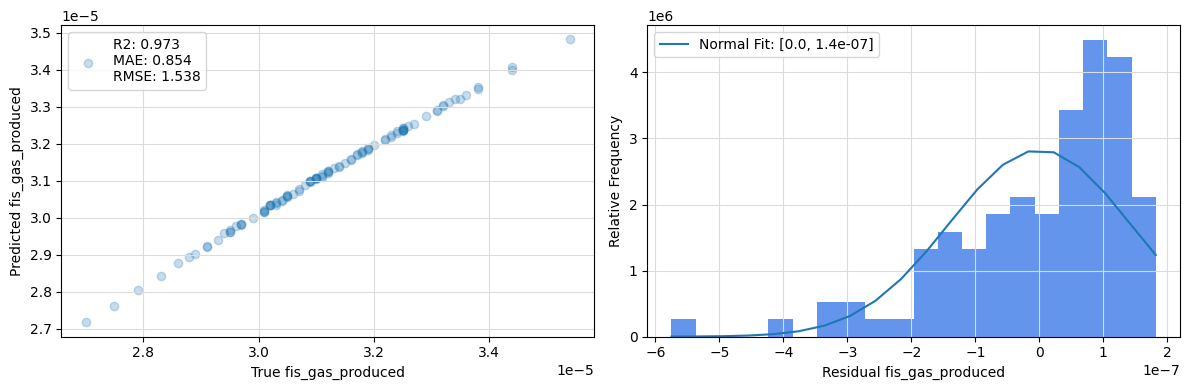

In [140]:
# --- Results - Performance
Y_PREDICTED = Y_SCALER.inverse_transform(model(X_TESTS_SCALED).detach())
Y_TRUE = Y_TESTS

i = 0

myR2 = R2(Y_TRUE, Y_PREDICTED); myMSE = MSE(Y_TRUE, Y_PREDICTED); myMAE = MAE(Y_TRUE, Y_PREDICTED)

fig, axs = plt.subplots(1,2, figsize=(12,4))

ax=axs[0]
ax.scatter(Y_TRUE[:,i], Y_PREDICTED[:,i], alpha=0.25, label=f"R2: {round(myR2,3)}\nMAE: {round(myMAE,3)}\nRMSE: {round(myMSE**0.5,3)}")
ax.set_xlabel(f"True {Y_features[i]}"); ax.set_ylabel(f"Predicted {Y_features[i]}"); ax.legend(); ax.grid(visible=True, color='gainsboro')

ax=axs[1]
residuals = Y_PREDICTED[:,i] - Y_TRUE[:,i]
pdf_fit = stats.norm.fit(residuals)
pdf_pdf = stats.norm.pdf(np.linspace(np.min(residuals),np.max(residuals),20), *pdf_fit)
ax.hist(residuals, bins=20, color='cornflowerblue', density=True)
ax.plot(np.linspace(np.min(residuals),np.max(residuals),20), pdf_pdf, label=f'Normal Fit: {[round(i,8) for i in pdf_fit]}')
ax.set_xlabel(f"Residual {Y_features[i]}"); ax.set_ylabel("Relative Frequency"); ax.grid(visible=True, color='gainsboro', label='Raw Data'); ax.legend()

fig.tight_layout()

In [137]:
# --- Symbolic Results
function_library = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','abs', '1/x', '1/x^2']
model.auto_symbolic(lib=function_library)

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with 0
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,0,6) with 0
fixing (0,0,7) with 0
fixing (0,0,8) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
fixing (0,1,4) with x, r2=0.6313116074624231, c=1
fixing (0,1,5) with 0
fixing (0,1,6) with 0
fixing (0,1,7) with x, r2=0.9648913077550121, c=1
fixing (0,1,8) with x, r2=0.9988134413981736, c=1
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with 0
fixing (0,2,4) with 0
fixing (0,2,5) with 0
fixing (0,2,6) with 0
fixing (0,2,7) with 0
fixing (0,2,8) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with 0
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,3,6) with 0
fixing (0,3,7) with x, r2=0.8636953738661819, c=1
fixing (0,3,8) with 0
fixing (0,4,0) with x^2, r2=0.997369027554105, c=2
fixing (0,4,1) with x, r2=0.10497027062674946

In [138]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4) #type:ignore

0.4298*x_11 - 10.329*(1 - 0.04*x_5)**2 + 10.3593